<a href="https://colab.research.google.com/github/wenxuan0923/My-notes/blob/master/Classification_on_imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Credit Card Fraud detection

In this note I will explore common techniques dealing with highly imbalanced dataset, and train a Deep neural network model for fraud detection. The following methods are covered here.

- Under-sampling methods: **NearMiss**
- Over-sampling methods: **SMOTE**
- Class weighting: `class_weight` in Keras model.fit

The dataset being used in this note come from Kaggle: <a target='_blank' href='https://www.kaggle.com/mlg-ulb/creditcardfraud'>Credit Card Fraud Detection</a>.

In [1]:
# Set up
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
from collections import Counter
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load data
data = pd.read_csv('creditcard.csv')
print('Data shape: ', data.shape)
display(data.head())

Data shape:  (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


####According to the intro page of the dataset:

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is **highly unbalanced**, the positive class (frauds) account for 0.172% of all transactions.

It contains **only numerical input** variables which are the **result of a PCA transformation**. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

> PCA assumes that the dataset is centered around the origin, which implies these V features have been scaled beforehand.

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [3]:
display(data.describe())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Target Variable

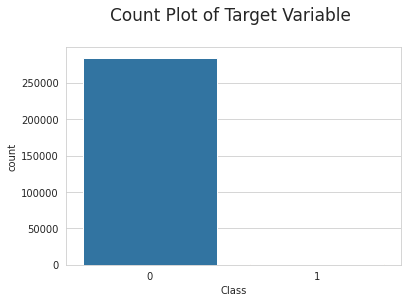

In [4]:
ax = sns.countplot('Class', data=data)
ax.set_title('Count Plot of Target Variable \n', fontsize=17)
plt.show()

In [5]:
# Percentage of target variable
data.Class.value_counts()/len(data)

0    0.998273
1    0.001727
Name: Class, dtype: float64

Positive class (frauds) account for only 0.172% of all transactions.

## Distribution of features 

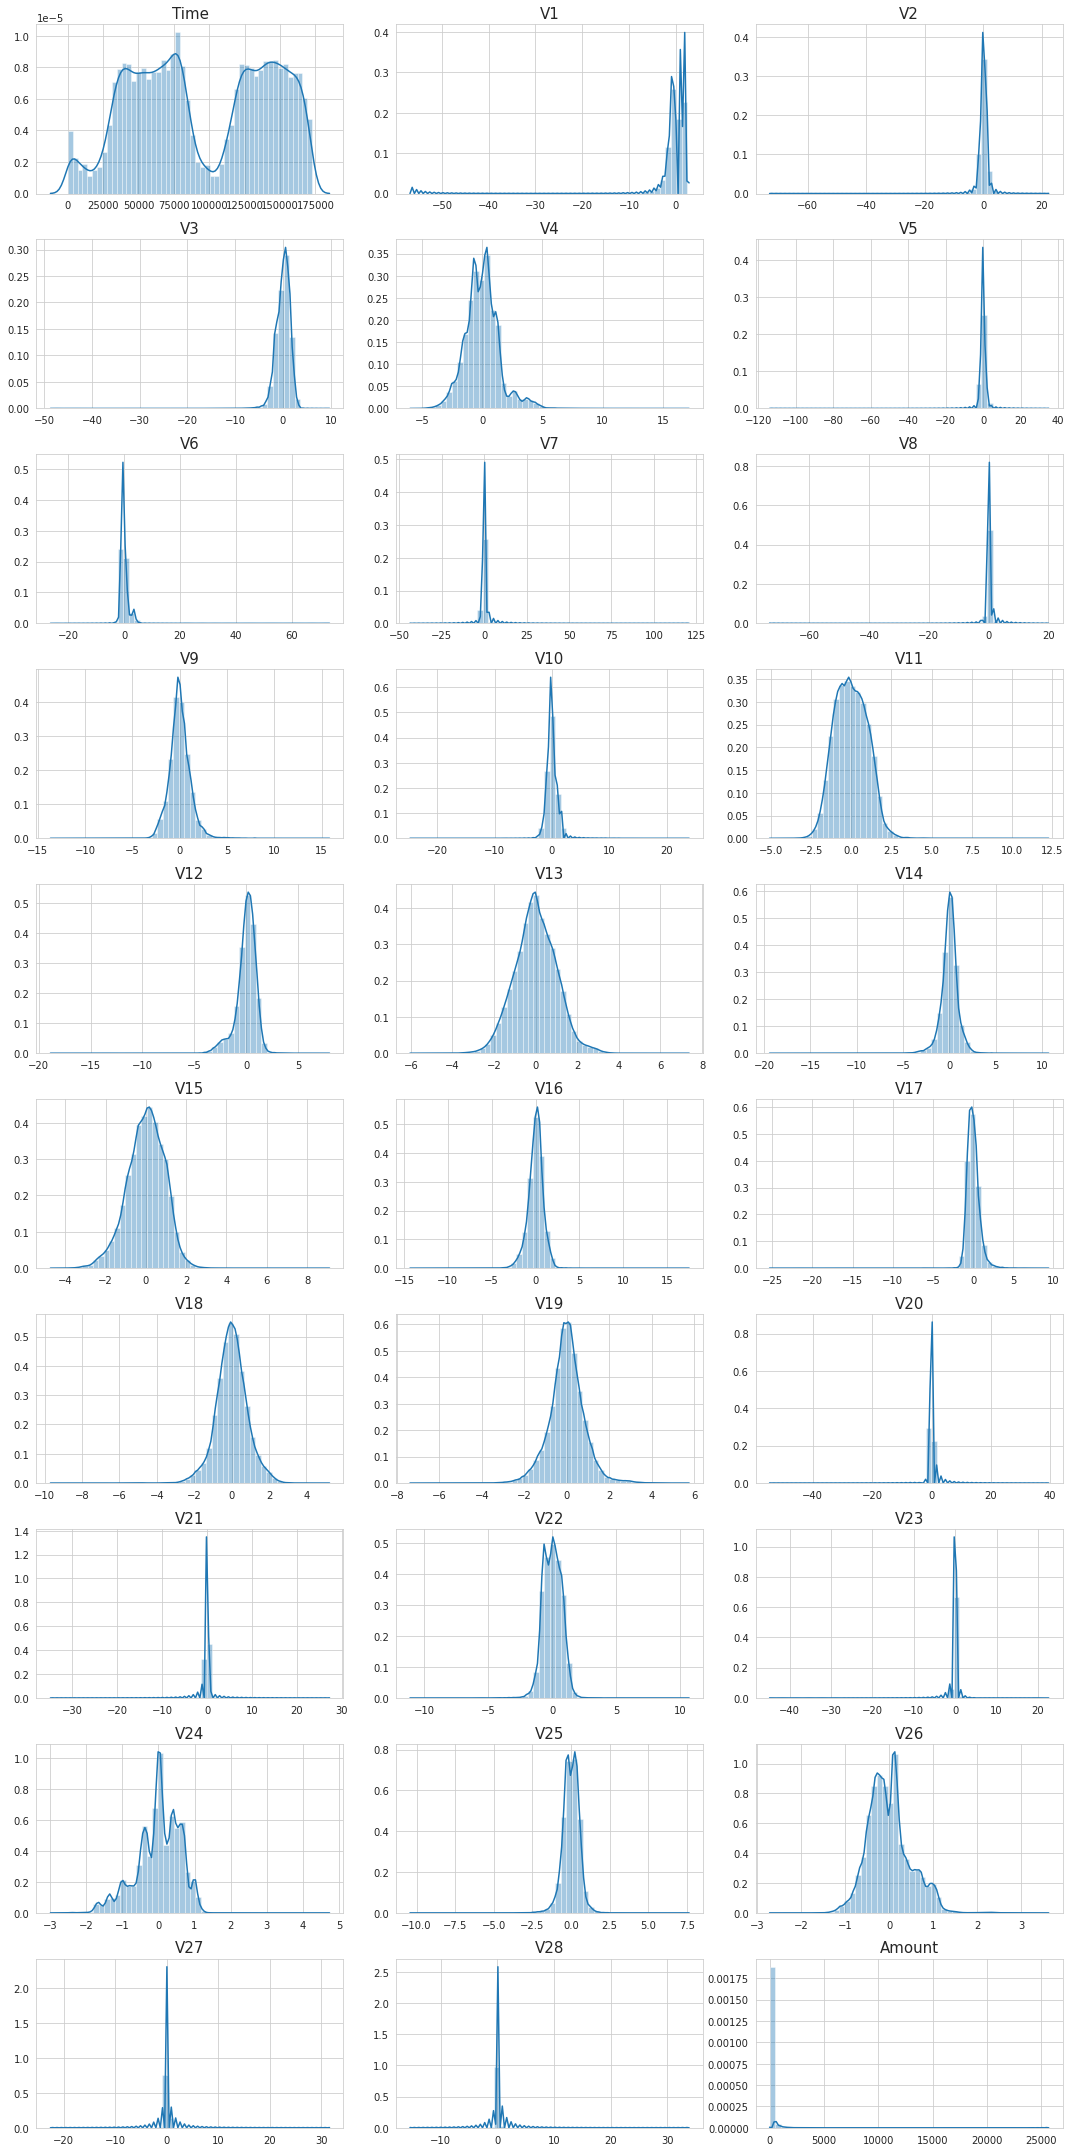

In [6]:
# Distribution of all features in the dataset
cols = list(data.columns)
cols.remove('Class')  # remove the target variable
num_rows = int(np.ceil(len(cols)/3))
fig, axs = plt.subplots(num_rows, 3, figsize=(15, 3*num_rows))
axs = axs.ravel()
for ax in axs[len(cols):]:
    ax.set_visible(False)
for i, col in enumerate(cols):
  sns.distplot(data[col], ax=axs[i])
  axs[i].set_xlabel('')
  axs[i].set_title(col, fontsize=15)
plt.tight_layout()
plt.show()

From the distribution of features, we can see that:
- All the **V** features have been scaled since they are the outputs of PCA
- A lot of the features are **highly skewed**, especially the Amount columns
- We need to scale the **Time** and **Amount** columns using some techniques like log transform.

Before we proceed with further analysis, let's process the data first such that they are have the same scale and less skewed. Besides, we want to get ready the train, test and validation sets for model fitting and evaluation.


In [0]:
clean_df = data.copy()
clean_df['Amount'] = np.log1p(clean_df['Amount'])
clean_df.drop('Time', axis=1, inplace=True)
features = clean_df.columns



**Overall**: 64% Train, 16% Validation, 20% test

In [0]:
train_df, test_df = train_test_split(clean_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)
x_train, y_train = train_df.drop('Class', axis=1), train_df['Class']
x_val, y_val = val_df.drop('Class', axis=1), val_df['Class']
x_test, y_test = test_df.drop('Class', axis=1), test_df['Class']

Clip the extreme values base on quantile of training set:

In [0]:
train_df = train_df.clip(train_df.quantile(0.05), train_df.quantile(0.95), axis=1)
test_df = test_df.clip(train_df.quantile(0.05), train_df.quantile(0.95), axis=1)
val_df = val_df.clip(train_df.quantile(0.05), train_df.quantile(0.95), axis=1)

The **StandardScaler** is only fit using the training data to ensure the model is not peeking at the validation or test sets.

In [0]:
scaler = StandardScaler()   # Standardize features to mean 0 variance 1
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

There are mainly two ways to address the problem of imbalanced dataset:

1. **Undersampling**: Randomly delete examples from the majority class. 

2. **Oversampling**: Randomly creates synthetic data from the minority class.

Importantly, these techniques can only be applied to the training dataset to reach a better fit of the models. The resampling is not applied to the test or evaluation set used to evaluate the performance of a model.

Now let's try start with Undersampling method.

## Undersampling: NearMiss

Random undersampling involves randomly deleting data from the majority class to achieve a more balanced dataset. However, it usually lead to information loss at the same time. Thus, instead of using random undersampling method, I will perform **under-sampling based on NearMiss methods**:

> When instances of two different classes are very close to each other, we remove the instances of the majority class to increase the spaces between the two classes. This helps in the classification process. To preserve as much infomation as possible while deleting data from the majority class. Here is the basic intuition:<br>
1. Find the distances between all instances of the majority class and the instances of the minority class. <br>
2. $n$ instances of the majority class that have the smallest distances to those in the minority class are selected. If there are $k$ instances in the minority class, the nearst method will result in the deletion of $k*n$ instances of the majority class.

The **imbalanced-learn** toolbox provides methods to under-sample (over-sample) a dataset. Check their <a target='_blank' href='https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.under_sampling'>official documents</a> for details.



NearMiss implements **3 different types of heuristic** which can be selected with the parameter `version`.

> Note: NearMiss heuristic rules are based on **nearest neighbors algorithm**. It's important to scale the data beforehand. 


**Version 1**: The model selects samples of the majority class for which **average distances** to the $k$ **closest instances** of the minority class is **smallest**.

**Version 2**: The model selects samples of the majority class for which **average distances** to the $k$ **farthest instances** of the minority class is **smallest**.

**Version 3**: First, for each minority class instance, their $M$ nearest-neighbors will be stored. Then, the majority class instances are selected for which the **average distance** to the $M$ nearest-neighbors is the **largest**.





In [7]:
from imblearn.under_sampling import NearMiss 
nm = NearMiss(sampling_strategy='majority', version=2)
x_nm, y_nm = nm.fit_resample(x_train, y_train)

# Check the new class distribution
print('Before Under-Sampling: ', Counter(y_train))
print('After Under-Sampling: ', Counter(y_nm))

Before Under-Sampling:  Counter({0: 181952, 1: 324})
After Under-Sampling:  Counter({0: 324, 1: 324})


## DNN model for fraud detection

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
METRICS = [
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = Sequential()
  model.add(Dense(16, activation='relu',
          input_shape=(x_train.shape[-1],)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid',
                  bias_initializer=output_bias))
  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss='BinaryCrossentropy',
      metrics=metrics)

  return model

In [0]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [11]:
nm_model = make_model()
nm_history = nm_model.fit(
    x_nm, y_nm,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_val, y_val))

Epoch 1/100
1/1 [==============================] - 1s 631ms/step - loss: 1.0936 - precision: 0.6236 - recall: 0.5062 - auc: 0.6090 - val_loss: 0.8007 - val_precision: 0.0012 - val_recall: 0.4359 - val_auc: 0.4460
Epoch 2/100
1/1 [==============================] - 0s 211ms/step - loss: 1.1432 - precision: 0.5872 - recall: 0.4259 - auc: 0.5847 - val_loss: 0.8029 - val_precision: 0.0014 - val_recall: 0.4744 - val_auc: 0.4738
Epoch 3/100
1/1 [==============================] - 0s 202ms/step - loss: 1.0696 - precision: 0.6375 - recall: 0.4938 - auc: 0.6384 - val_loss: 0.8053 - val_precision: 0.0015 - val_recall: 0.5385 - val_auc: 0.5020
Epoch 4/100
1/1 [==============================] - 0s 200ms/step - loss: 0.9628 - precision: 0.6431 - recall: 0.5340 - auc: 0.6575 - val_loss: 0.8076 - val_precision: 0.0016 - val_recall: 0.5769 - val_auc: 0.5317
Epoch 5/100
1/1 [==============================] - 0s 195ms/step - loss: 0.8508 - precision: 0.7126 - recall: 0.5586 - auc: 0.7153 - val_loss: 0.809

In [0]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  f = plt.figure(figsize=(12, 6))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    ax = f.add_subplot(2, 2, n+1)
    ax.plot(history.epoch, history.history[metric], label='Train')
    ax.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    plt.suptitle('Training history', y=1.05, fontsize=17)
    plt.legend()
    plt.tight_layout()

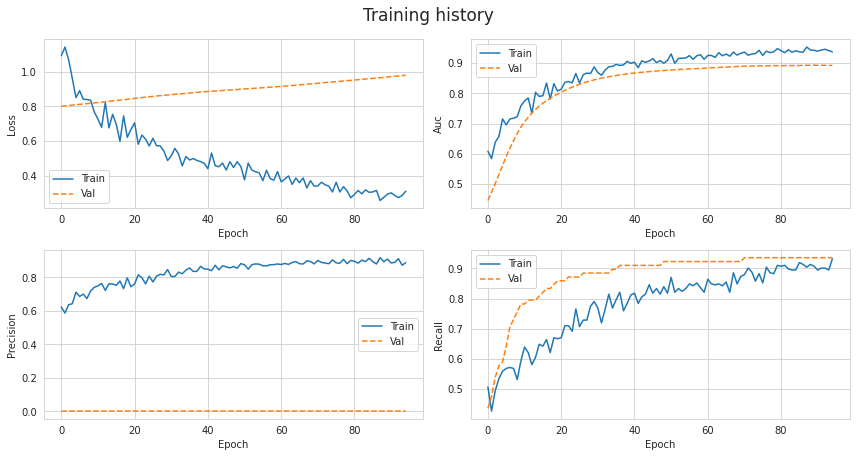

In [13]:
plot_metrics(nm_history)

In [0]:
def plot_roc(model):
  train_predictions = model.predict(x_train, batch_size=BATCH_SIZE)
  test_predictions = model.predict(x_test, batch_size=BATCH_SIZE)
  plt.figure(figsize=(8, 5))
  fp, tp, _ = sklearn.metrics.roc_curve(y_train, train_predictions)
  plt.plot(fp, tp, label='Train Baseline', linewidth=2)
  fp, tp, _ = sklearn.metrics.roc_curve(y_test, test_predictions)
  print('AUC for test set: ', sklearn.metrics.auc(fp, tp), '\n')
  plt.plot(fp, tp, label='Test Baseline', linewidth=2, linestyle='--')
  plt.legend(loc='lower right')
  plt.title('ROC curve', fontsize=17)
  plt.show()

AUC for test set:  0.8746539988434066 



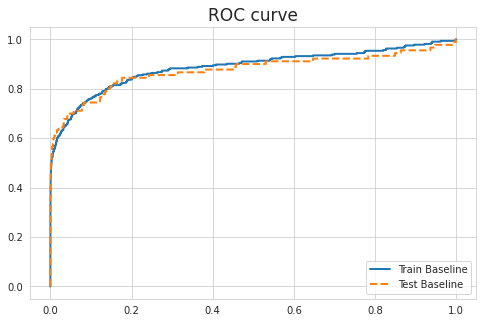

In [15]:
plot_roc(nm_model)

## Oversampling: SMOTE

SMOTE aims to balance class distribution by randomly increasing minority class examples by replicating them. SMOTE synthesizes new minority instances between existing minority instances. It generates the **virtual** training records by linear interpolation using the k-nearest neighbors for each example in the minority class.

The basic intuition of SMOTE Algorithm is:<br><br>

1. Set the sampling rate $N = \frac{\text{number of instances in majority class}}{\text{number of instances in minority class}}$. <br><br>
2. For every data point $x$ in the minority class, $N$ random samples in its k-nearest neighbors (in the minority set) are selected.
Let's denote the set of these $N$ samples $K$.<br>
3. For each sample $x_k \in K$, a new sample is synthesized using the formula: <br><br>
$$x' = x + rand(0, 1)*|x - x_k|$$

This way, $N$ virtual data is created for every data point in the minority class, which lead to a balanced dataset.

Similarly, an implementation of the SMOTE method is available in the imblearn pakage, check 
<a href='https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE'>imblearn.over_sampling.SMOTE</a> for more details.

In [16]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
x_sm, y_sm = sm.fit_resample(x_train, y_train)

# Check the new class distribution
print('Before Under-Sampling: ', Counter(y_train))
print('After Under-Sampling: ', Counter(y_sm))

Before Under-Sampling:  Counter({0: 181952, 1: 324})
After Under-Sampling:  Counter({0: 181952, 1: 181952})


In [17]:
sm_model = make_model()
sm_history = sm_model.fit(
    x_sm, y_sm,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_val, y_val))

Epoch 1/100
178/178 [==============================] - 2s 13ms/step - loss: 0.7872 - precision: 0.5005 - recall: 0.9022 - auc: 0.8119 - val_loss: 0.6169 - val_precision: 0.0044 - val_recall: 0.9231 - val_auc: 0.9202
Epoch 2/100
178/178 [==============================] - 2s 10ms/step - loss: 0.3795 - precision: 0.7320 - recall: 0.9409 - auc: 0.9432 - val_loss: 0.2728 - val_precision: 0.0218 - val_recall: 0.8974 - val_auc: 0.9456
Epoch 3/100
178/178 [==============================] - 2s 10ms/step - loss: 0.2774 - precision: 0.8101 - recall: 0.9430 - auc: 0.9645 - val_loss: 0.1651 - val_precision: 0.0403 - val_recall: 0.8974 - val_auc: 0.9684
Epoch 4/100
178/178 [==============================] - 2s 10ms/step - loss: 0.2287 - precision: 0.8444 - recall: 0.9489 - auc: 0.9742 - val_loss: 0.1197 - val_precision: 0.0486 - val_recall: 0.8974 - val_auc: 0.9788
Epoch 5/100
178/178 [==============================] - 2s 10ms/step - loss: 0.1979 - precision: 0.8671 - recall: 0.9520 - auc: 0.9796 - 

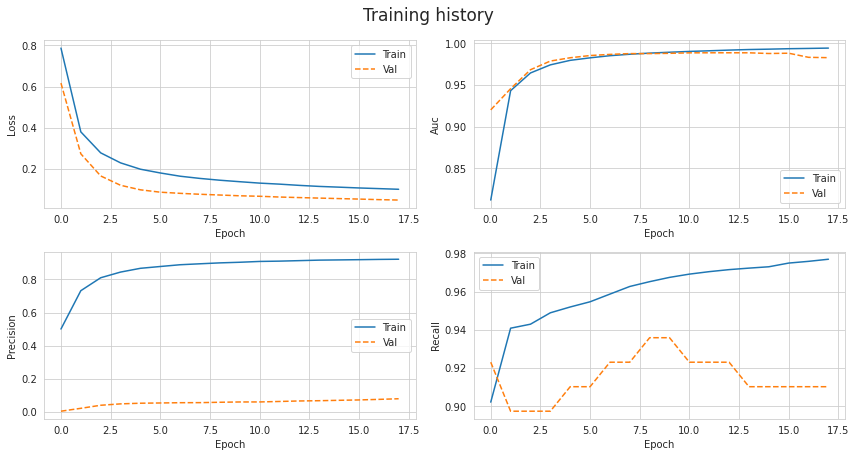

In [18]:
plot_metrics(sm_history)

AUC for test set:  0.9668662376330472 



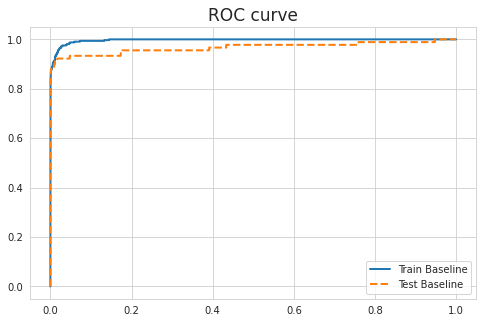

In [19]:
plot_roc(sm_model)

## Class Weight

Instead of performing any over-sampling or under-sampling techiniques to create a balanced dataset, one can simply put more weight on the instances in the minority class by setting `class_weight` when training DNN model.



In [20]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = np.bincount(data['Class'])
total = len(data)
weight_0 = (1 / neg)*(total)/2.0 
weight_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_0, 1: weight_1}

print('Weight for class 0: {:.2f}'.format(weight_0))
print('Weight for class 1: {:.2f}'.format(weight_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [21]:
cw_model = make_model()
cw_history = cw_model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    class_weight=class_weight,
    validation_data=(x_val, y_val))

Epoch 1/100
90/90 [==============================] - 1s 15ms/step - loss: 1.0163 - precision: 0.0019 - recall: 0.8184 - auc: 0.7205 - val_loss: 1.2118 - val_precision: 0.0017 - val_recall: 1.0000 - val_auc: 0.9059
Epoch 2/100
90/90 [==============================] - 1s 13ms/step - loss: 0.6587 - precision: 0.0020 - recall: 0.9383 - auc: 0.8166 - val_loss: 0.9211 - val_precision: 0.0020 - val_recall: 0.9872 - val_auc: 0.9362
Epoch 3/100
90/90 [==============================] - 1s 11ms/step - loss: 0.5324 - precision: 0.0025 - recall: 0.9136 - auc: 0.8779 - val_loss: 0.7333 - val_precision: 0.0032 - val_recall: 0.9487 - val_auc: 0.9466
Epoch 4/100
90/90 [==============================] - 1s 11ms/step - loss: 0.4457 - precision: 0.0035 - recall: 0.9290 - auc: 0.9205 - val_loss: 0.5916 - val_precision: 0.0068 - val_recall: 0.9359 - val_auc: 0.9518
Epoch 5/100
90/90 [==============================] - 1s 12ms/step - loss: 0.3905 - precision: 0.0047 - recall: 0.9074 - auc: 0.9288 - val_loss: 

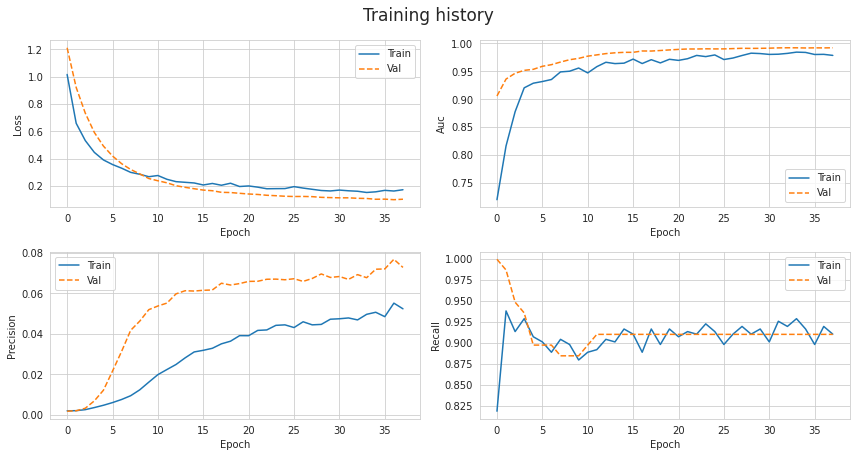

In [22]:
plot_metrics(cw_history)

AUC for test set:  0.9745853261124398 



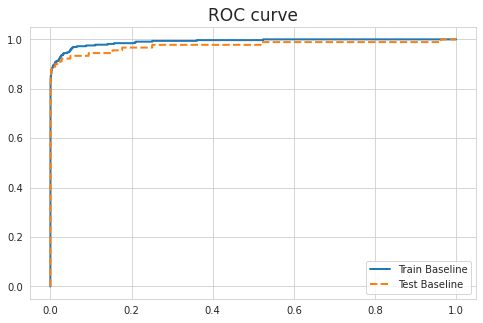

In [23]:
plot_roc(cw_model)

According to the introduction of the dataset on Kaggle:
> "Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification."
 
Base on the final AUC(Area Under the Curve) on the test set: **Class Weight > SMOTE > NearMiss** in this example.